# Iris Flowers Question

This notebook is organized as follows:

1. Exploratory data exploration
2. Specification of the initial model
3. Inference of the posterior
4. Predictive posterior checks and sensitivity analysis
5. Expansion of the model and evaluation of the expanded model


In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import arviz as az
sns.set_style("whitegrid")
from scipy import stats

In [137]:
#Load Dataset
iris_df = pd.read_csv("data/iris.csv")

# 1. Exploratory Data Analysis

In [138]:
print(f"Number of data points per class:\n{iris_df['species'].value_counts()}")

Number of data points per class:
virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64


There are 4 features that we can use. Let's see what we can observe and conclude from each one, separately

In [139]:
iris_features = list(iris_df.columns)[:4]

### Single feature Analysis
### Histogram Plots per feature 

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


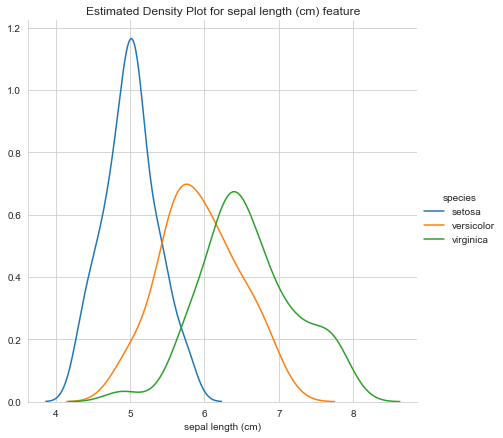

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


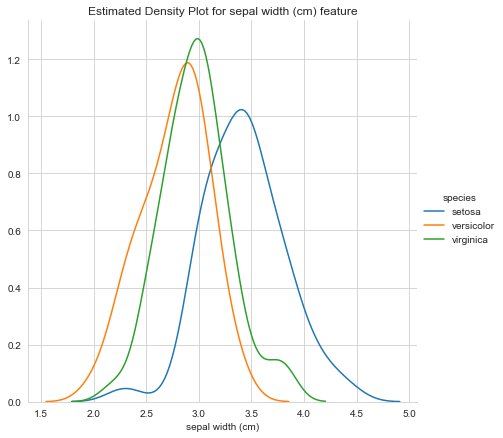

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


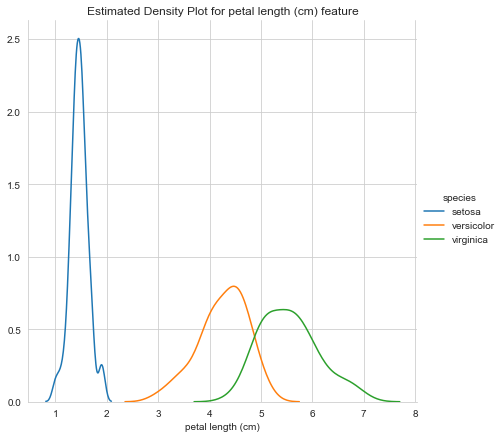

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


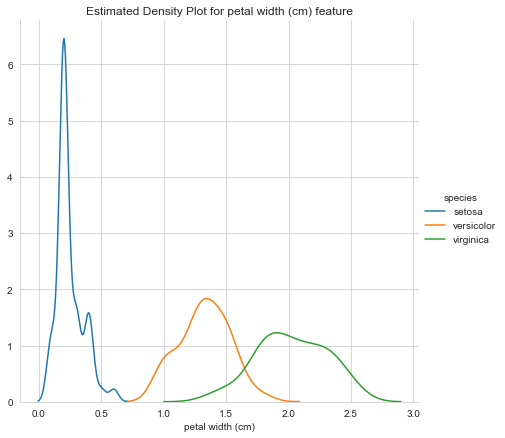

In [140]:
for feature in iris_features:
    sns.FacetGrid(iris_df, hue="species", size=6).map(sns.kdeplot, feature).add_legend()
    plt.title(f"Estimated Density Plot for {feature} feature")
    plt.show()

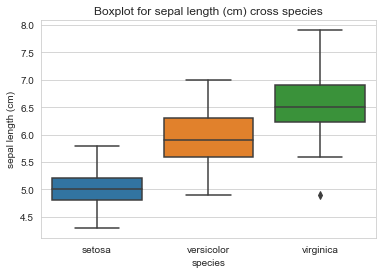

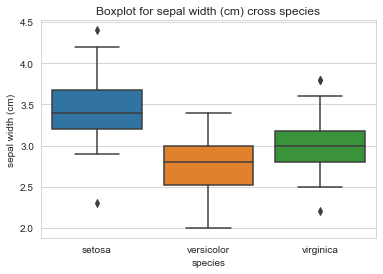

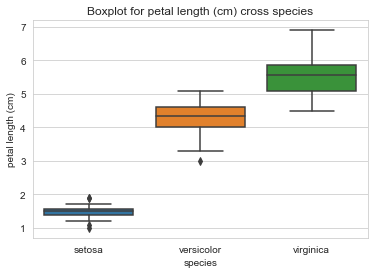

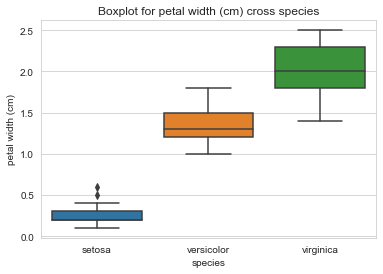

In [141]:
# the boxplot feature of seaborn is also useful to look at individual features
for feature in iris_features:
    sns.boxplot(x="species", y=feature, data=iris_df)
    plt.title(f"Boxplot for {feature} cross species")
    plt.show()
    

### Observations and Conclusions from Single Feature analysis


We can see that:
* Early on we can see that using the features petal length and width differ between the species, where the other features are more overlapping.
* Furthermore, we can see that using these two features, we can distinguish the setosa species from the other two.



## 2D Feature-Pairs Scatter Plots
Here we'll try to observe whether there are any correlations between pair of features:

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


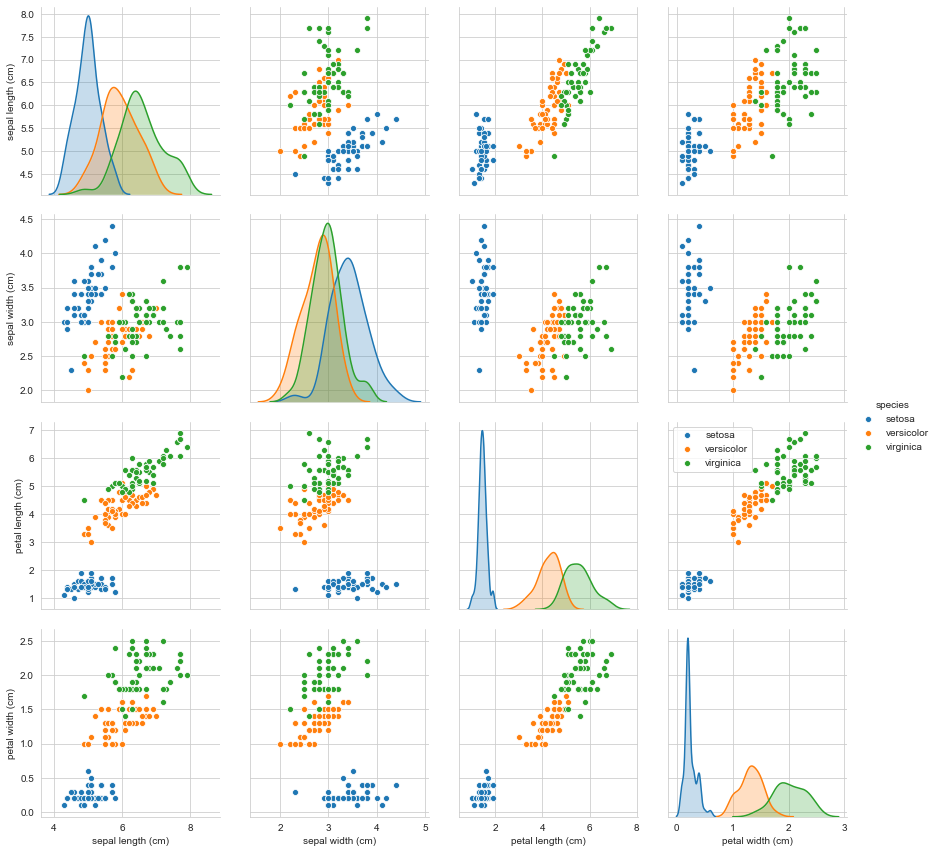

In [142]:
sns.set_style("whitegrid")
sns.pairplot(iris_df,hue="species",size=3)
plt.legend()
plt.show()


## 2D Feature-Pairs Scatter Plot Observation and Conclusions

We can see that:
* Blue points can be relatively easily separated from red and green by drawing a line, in most single features and feature-pairs.
* Thus, by using almost any feature, we can distinguish Setosa flowers from others.
* But red and green data points (other species) cannot be easily separated.
* Separating Versicolor from Viginica is much harder as they have considerable overlap.
* petal length and petal width are the most useful features to identify various flower types.
* Petal length and petal width are (positively) correlated
* Sepal length is (positively) correlated to both petal length and pedal width (but weaker correlation than the above).

In [143]:
# to further observe the correlations we can plot the correlation matrix
iris_df.corr()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000

Using the correlation matrix we can quantify the relations we have seen in the plots above.
* Indeed, the petal width and petal length are strongly correlated with a pearson correlation of 0.96.
Therefore, we should consider using only one of the two features, if this is not a case of the reversed Simpson's paradox (is investigated next).
* Sepal length is also strongly correlated with petal length (not as strongly as petal width), but still, has a high correlation co-efficient of 0.87.
* Sepal length is also correlated with petal width (which can be expected), with a correlation co-efficient of 0.82

In [144]:
# It is important to see that these relations exists also per species
for sp in iris_df.species.unique():
    print("Correlation matrix for "+sp)
    display(iris_df[iris_df.species == sp].corr())

Correlation matrix for setosa


sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000          0.742547           0.267176   
sepal width (cm)            0.742547          1.000000           0.177700   
petal length (cm)           0.267176          0.177700           1.000000   
petal width (cm)            0.278098          0.232752           0.331630   

                   petal width (cm)  
sepal length (cm)          0.278098  
sepal width (cm)           0.232752  
petal length (cm)          0.331630  
petal width (cm)           1.000000

Correlation matrix for versicolor


sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000          0.525911           0.754049   
sepal width (cm)            0.525911          1.000000           0.560522   
petal length (cm)           0.754049          0.560522           1.000000   
petal width (cm)            0.546461          0.663999           0.786668   

                   petal width (cm)  
sepal length (cm)          0.546461  
sepal width (cm)           0.663999  
petal length (cm)          0.786668  
petal width (cm)           1.000000

Correlation matrix for virginica


sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000          0.457228           0.864225   
sepal width (cm)            0.457228          1.000000           0.401045   
petal length (cm)           0.864225          0.401045           1.000000   
petal width (cm)            0.281108          0.537728           0.322108   

                   petal width (cm)  
sepal length (cm)          0.281108  
sepal width (cm)           0.537728  
petal length (cm)          0.322108  
petal width (cm)           1.000000

We can see that when considering each species but itself, we see much lower correlations, and different ones between the species, for example:
* In the setosa there is only a weak (0.33) correlation between petal length and width, while in the versicolor it to much  stronger (0.78).
 * Same goes for the high correlation between sepal length and petal length in the virginica (0.86) and the versicolor (0.75) while in the setosa it is only 0.26.



### Parallel Coordinates - multivariate visualization technique 
Shows the features for each data sample

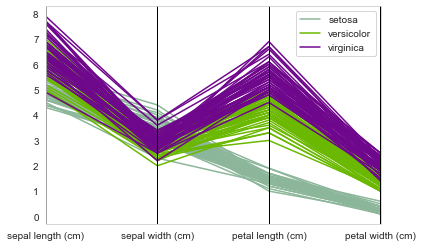

In [145]:

pd.plotting.parallel_coordinates(iris_df, "species")

### Summary Statistics:

In [146]:

print("All species:")
for feature in iris_features:
    print(f"Mean of {feature}:\t\t {iris_df[feature].mean():.3f}")
print()
for feature in iris_features:
    print(f"Var of {feature}:\t\t {iris_df[feature].var():.3f}")

All species:
Mean of sepal length (cm):		 5.843
Mean of sepal width (cm):		 3.057
Mean of petal length (cm):		 3.758
Mean of petal width (cm):		 1.199

Var of sepal length (cm):		 0.686
Var of sepal width (cm):		 0.190
Var of petal length (cm):		 3.116
Var of petal width (cm):		 0.581


Checking for outliers:

Outliers in data might effect the inference. We will check to see if there are any "out of the ordinary" data points that we might want to exclude from the data set.

In [147]:
# remove all rows that have outliers in at least one column (feature)

outliers = iris_df[(np.abs(stats.zscore(iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)']])) > 3).all(axis=1)]

if len(outliers) == 0:
    print("Not outliers in data")
else:
    display(outliers)

Not outliers in data


## EDA Conslusions:

We can see that there are 3 group that can be modeled as a GMM.
While the setosa can be easily distinguished from the other species, separating the other two might be a challange.
Another thing to note is that maybe using only the pedal length as a feature might be useful, due to the difference in its values between the three species.

# 2. Specification of the model

### Prep data

In [148]:
# prep data
iris_numpy = iris_df.to_numpy()
X, Y = iris_numpy[:,:4], iris_numpy[:,4]

# Bayesian Model
As was suggested:

1. reduce the dimensionality by applying linear regression: transforming the dataset from 4D to 1D.
2. run 1D gmm with 3 compnents on the resulting dataset.

$$
betas = \beta_1, \ \beta_2, \ \beta_3, \ \beta_4 \sim dirichlet(\text{pca_based_prior})\\
x\_1d = x\_4d \ @ \ betas \\
\text{adjusted for negative pca components}
\\
\\
\mu_1, \ \mu_2, \ \mu_3 \sim N(0, 1)\\
\sigma \sim N(1,0.5)\\
\\
x\_1d \sim \sum_{i=1}^{3} \pi_i * N(\mu_i, \sigma)\\
$$

## Estimating Prior via PCA

In [149]:
from sklearn.decomposition import PCA

In [150]:
pca = PCA(n_components=1)
pca.fit(X)
X_1dim = pca.transform(X)

In [151]:
labels = set(Y)

In [152]:
iris_1dim = {}
for label in labels:
    iris_1dim[label] = X_1dim[Y==label]

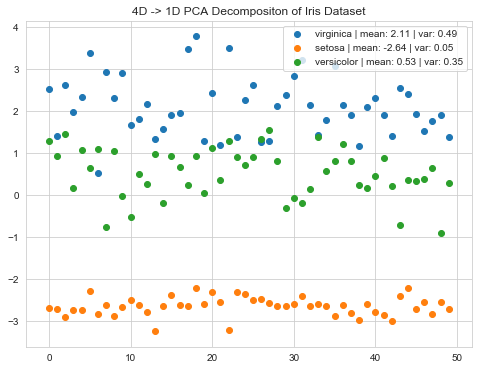

In [153]:
plt.figure(figsize=(8,6))
plt.title("4D -> 1D PCA Decompositon of Iris Dataset")
pca_data_means = []
for label in labels:
    data1dim = iris_1dim[label]
    mean = np.mean(data1dim)
    pca_data_means.append(mean)
    var = np.var(data1dim)
    plt.scatter(range(len(data1dim)), data1dim, label=f"{label} | mean: {mean:.2f} | var: {var:.2f}")
plt.legend()
plt.show()

In [154]:
print(f"Principal axes in feature space, representing the directions of maximum variance in the data: \n {pca.components_}")

Principal axes in feature space, representing the directions of maximum variance in the data: 
 [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]]


In [155]:
# new
df_iris_norm = iris_df.drop(columns = 'species').copy()
for col in df_iris_norm.columns:
    df_iris_norm[[col]] = df_iris_norm[[col]] - df_iris_norm[[col]].mean()
X_norm_2 = df_iris_norm.to_numpy()
# Adjusted for 2nd component is negative
X_norm_3 = X_norm_2.copy()
X_norm_3[:,1] *= -1

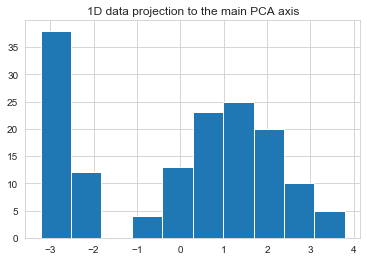

For later prior definitions, we want to get the mean of the transformed features using PCA values (for GMM clusters' mus).
 Using normalized data, the mean is [2.109208894907504, -2.6424154639468487, 0.5332065690393432]
The PCA component are 
 [ 0.36138659 -0.08452251  0.85667061  0.3582892 ] 


In [161]:
# normalize weights
pca_comp_abs = np.expand_dims(np.abs(pca.components_[0]), axis = 1)
pca_comp_norm = np.array([x/pca_comp_abs.sum() for x in pca_comp_abs])
# For mu priors:
x_1d = np.dot(X_norm_3,pca_comp_abs)
plt.hist(x_1d)
plt.title("1D data projection to the main PCA axis")
plt.show()
print(f"For later prior definitions, we want to get the mean of the transformed features using PCA values (for GMM clusters' mus).\n Using normalized data, the mean is {pca_data_means}" )
print(f"The PCA component are \n {pca.components_[0]} ")


In [162]:
import pystan

In [218]:
gmm_1d = """
data {
    int<lower=1> D; // input dimensions
    int<lower=0> N; // data points
    int<lower=1> k; // components number
    matrix[N,D] x; //model assumes that the data is normalized (x-x_mean)
    real mu_prior[k]; // prior for mus
    vector[D] pca_comp;
}


parameters
{
    simplex[D] beta;
    simplex[k] pi; //cluster weights
    real mu[k]; //clusters' mu
    real<lower=0> sigma; //clusters' sigma 
}

model {
    real ps[k]; //probability for each cluster
    vector[N] x_1d;

    pi ~ dirichlet([1,1,1]');
    

    beta ~ dirichlet(pca_comp);

    for (i in 1:N){
        x_1d[i] = beta[1] * x[i,1] + beta[2] * x[i,2] + beta[3] * x[i,3] + beta[4] * x[i,4];
    }
    for (i in 1:k){
        mu[i] ~ normal(mu_prior[i], 1); 
        sigma ~ normal(1, 0.1); //define a better prior
    }

    for(i in 1:N){
        for(j in 1:k){
            ps[j] <- log(pi[j]) + normal_log(x_1d[i], mu[j], sigma);
        }
        increment_log_prob(log_sum_exp(ps));
    }

}

"""

In [219]:
gmm_1d_model = pystan.StanModel(model_code=gmm_1d)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2239c37b5a76b293aacc017f7cebb744 NOW.


In [221]:
N = len(iris_df)
D = 4
k = 3

stan_data = {'D': D, 'N': N, 'k': k, 'x': X_norm_3, 'mu_prior':[0,0,0], 'pca_comp':pca_comp_abs.reshape(4,)} 
fit = gmm_1d_model.sampling(data=stan_data, iter=1000, chains=4)

print('Sampling finished.')

Sampling finished.


In [222]:
print(fit)

Inference for Stan model: anon_model_2239c37b5a76b293aacc017f7cebb744.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.15  2.7e-3   0.07 6.2e-3    0.1   0.15   0.19   0.27    595   1.01
beta[2]   0.82  1.6e-3   0.06   0.71   0.78   0.82   0.86   0.94   1310    1.0
beta[3] 5.9e-3  1.4e-4 6.6e-3 8.6e-5 1.4e-3 3.6e-3 8.0e-3   0.02   2321    1.0
beta[4]   0.03  1.6e-3   0.04 1.7e-6 1.2e-3 9.6e-3   0.03   0.14    557   1.01
pi[1]     0.33    0.01   0.29 4.5e-3   0.08   0.25   0.55   0.92    690    1.0
pi[2]     0.33    0.01   0.28 4.7e-3   0.08   0.26   0.53   0.94    750    1.0
pi[3]     0.34    0.01   0.29 2.7e-3   0.08   0.26   0.56   0.92    589    1.0
mu[1]    -0.01    0.02   0.29  -0.64  -0.09-8.0e-3   0.08   0.56    352   1.01
mu[2]  -4.8e-3    0.01   0.25  -0.58  -0.08 4.0e-3   0.09   0.46    524    1.0
mu[3]    -0.01    0.02 

# 3. Posterior evaluations

In [42]:
def posterior_plot_iris(fit_results, params = ["beta", "pi", "mu","sigma"]):
    fit = fit_results
    fig = plt.figure(figsize=(16,8))
    for i, param in enumerate(params):
        ax = plt.subplot(2,3,i+1)
        if param != "sigma":
            handles = []
            for j in range(fit[param].shape[1]):
                ax.hist(fit[param][:,j], label = param + f"[{j}]", alpha = 0.5)
                
            ax.legend()
                
        else: 
            ax.hist(fit[param], label = param)
        
        ax.set_title(param)
        
    plt.suptitle("Posteriors", fontsize = 18)
    plt.show()

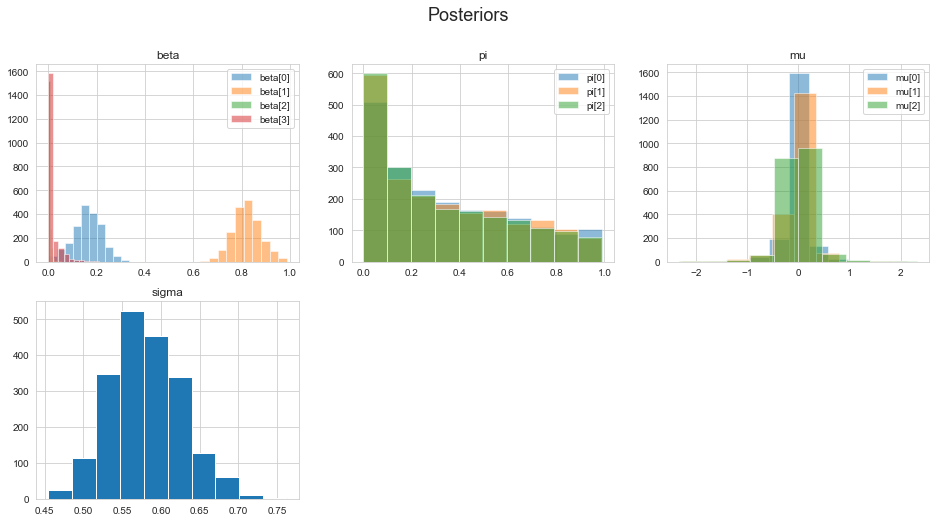

In [43]:
posterior_plot_iris(fit)

# 4. Predictive posterior checks and sensitivity analysis

Maybe use https://pymc-devs.github.io/pymc/modelchecking.html
https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501



### Posterior distribution of the parameters.

Also showing 95% confidence interval, posterior mean and distribution.

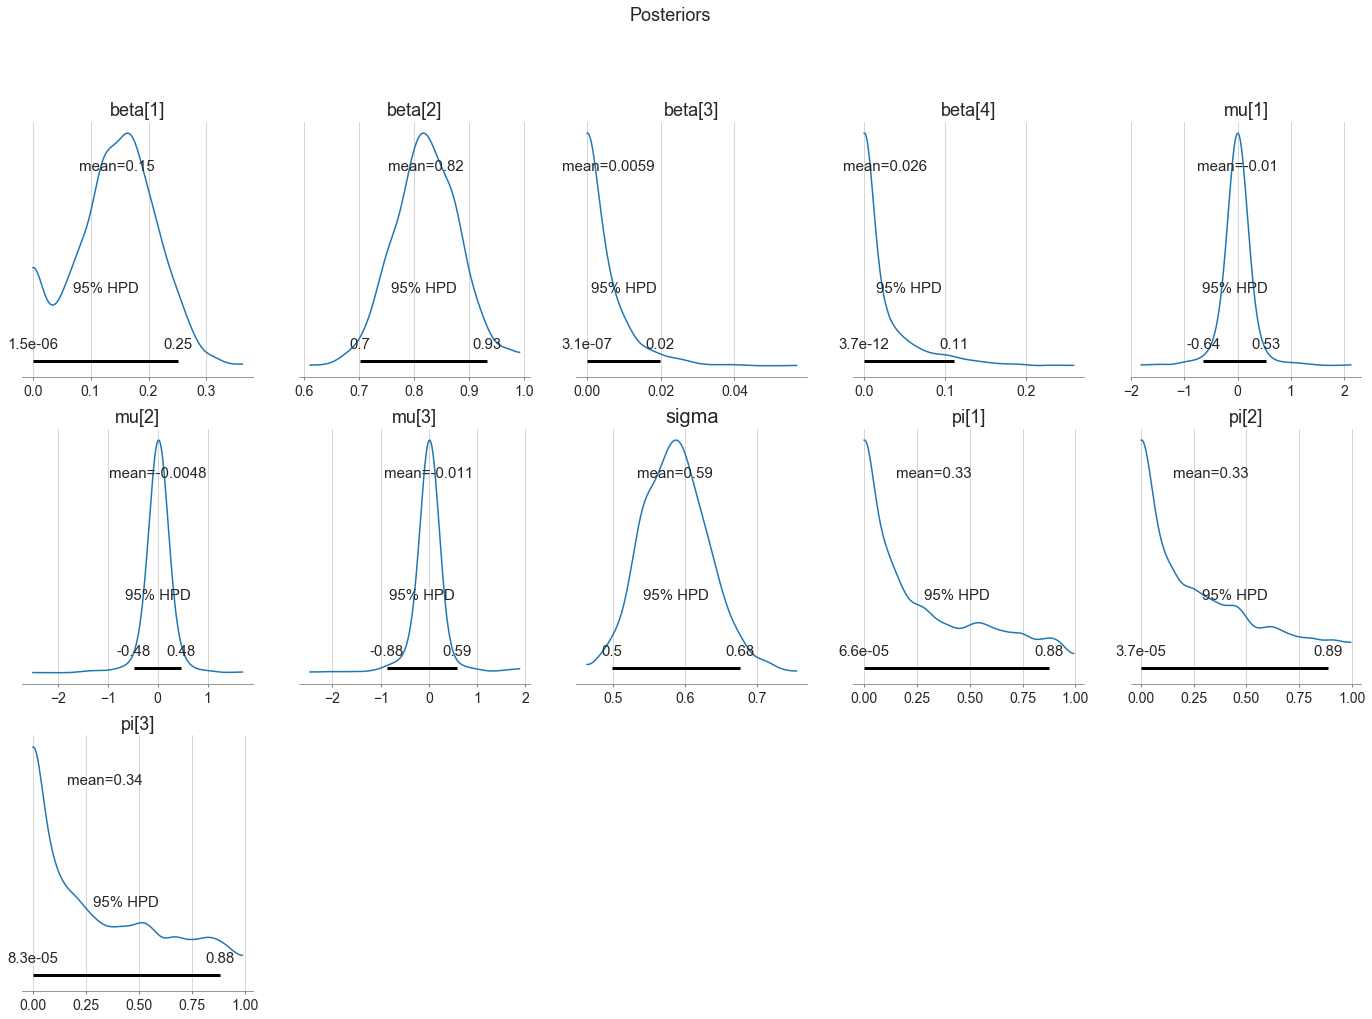

In [224]:
credible_interval = 0.95
params = ['beta','mu','sigma','pi']
fig = plt.figure(figsize=(24,16))

i = 1
for param in params:
    if param != "sigma":
        for j in range(fit[param].shape[1]):
            ax = plt.subplot(3,5,i)
            az.plot_posterior(fit[param][:,j], ax = ax, credible_interval =credible_interval)
            ax.set_title(param + f"[{j+1}]", fontsize = 18)
            i+=1
            
            
    else: 
        ax = plt.subplot(3,5,i)
        az.plot_posterior(fit[param], ax = ax, credible_interval =credible_interval)
        ax.set_title(param, fontsize = 20)
        i+=1
        
    
plt.suptitle("Posteriors", fontsize = 18)
plt.show()

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [225]:
import pymc3 as pm

for param in params:
    if param != "sigma":
        for j in range(fit[param].shape[1]):
            # reshape to seperate chains
            gelman_values = pm.gelman_rubin(fit[param][:,j].reshape(4,-1))
            print(f" {param}[{j+1}]'s gelman rubin value is: {gelman_values}")

    else:
        gelman_values = pm.gelman_rubin(fit[param].reshape(4,-1))
        print(f" {param}'s gelman rubin value is: {gelman_values}")

C:\Users\t-merone\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


 beta[1]'s gelman rubin value is: 1.0013303801155051
 beta[2]'s gelman rubin value is: 1.0003576554286184
 beta[3]'s gelman rubin value is: 1.0030913995774047
 beta[4]'s gelman rubin value is: 1.0087199817258745
 mu[1]'s gelman rubin value is: 1.003735506066976
 mu[2]'s gelman rubin value is: 1.0010916671687582
 mu[3]'s gelman rubin value is: 1.0068615502043488
 sigma's gelman rubin value is: 1.0025294960982267
 pi[1]'s gelman rubin value is: 1.002265755896834
 pi[2]'s gelman rubin value is: 1.0007040158247282
 pi[3]'s gelman rubin value is: 1.0005170611026437


All values are close to 1 so it's plausible to assume convergence.

## Posterior Predictive Checks

In [46]:
def draw_gmm(pi, mu, sigma):
    #choose the cluster according to its' weights
    x = np.random.rand()
    chosen_index = 2
    if x <= pi[0]:
        chosen_index = 0
    elif x <= pi[0]+pi[1]:
        chosen_index = 1
    # sample from this cluster using its parameters
    x_1d_sim = np.random.normal(mu[chosen_index],sigma)
    return x_1d_sim

def transform_df_regression(betas, data_df):
    transformed_data_df = data_df @ np.transpose(np.array(betas))
    return transformed_data_df

def simulate_latent_1d(NSIM, N_obs, pi_samples, mu_samples, sigma_samples, test_variables):
    '''
    In each simulation we will sample N_obs latent variables (1d) from the posterior samples.
    N_obs = length of original data. Meaning, in each simulation we will simulate a 1D dataset.
    test_variables a list of test variables, for example, ["mean","max","std"]

    returns:
    1. a list of size NSIM. Each element is a list of size N_obs (==len(data))
    2. test variables for each simulation in a dataframe
    '''
    test_variables_df = pd.DataFrame(columns = test_variables)
    simulations = []
    for sim in range(NSIM):
        # sample mixture parameters from posterior
        ind = np.random.randint(len(pi_samples))
        simulation = []
        pi, mu, sigma = pi_samples[ind,:], mu_samples[ind,:], sigma_samples[ind]
        for i in range(N_obs):
            simulation.append(draw_gmm(pi, mu, sigma)) #returns a single x1d sample
        #simulation is now a list of size N_obs
        simulations.append(pd.Series(simulation)) # returnin a pd.series for consistancy with next function
        agg = pd.Series(simulation).agg(test_variables)
        for var in test_variables:
            test_variables_df.at[sim, var] = agg[var]
    #simulation will be a list of NSIM simulation lists
    return simulations, test_variables_df


def simulate_transformed_df(NSIM, data_df, beta_samples, test_variables):
    '''
    In each simulation we will sample a transformed dataset (4D X N_obs) from the posterior samples of the regression       coefficients.
    N_obs = length of original data. Meaning, in each simulation we will simulate a 1D dataset.
    test_variables a list of test variables, for example, ["mean","max","std"]

    returns:
    1. a list of size NSIM. Each element is a numpy array of size len(data_df)
    2. test variables for each simulation in a dataframe
    '''
    test_variables_df = pd.DataFrame(columns = test_variables)
    simulations = []
    for sim in range(NSIM):
        # sample regression coefficients for posteriors
        ind = np.random.randint(len(beta_samples))
        betas = beta_samples[ind,:]
        df_transformed = transform_df_regression(betas, data_df)
        simulations.append(df_transformed.values)
        agg = df_transformed.agg(test_variables)
        for var in test_variables:
            test_variables_df.at[sim, var] = agg[var]
    return simulations, test_variables_df # a list of array of length == len(data_df)

In [47]:
NSIM = 1000
test_variables = ['min','max','mean','median','std']
# forward points
transformed_data_simulations, transformed_data_test_vars = simulate_transformed_df(NSIM, iris_df.drop(columns = "species"), \
    fit["beta"], test_variables)
# backward points
simulated_1d_data, simulated_1d_test_vars = simulate_latent_1d(NSIM, len(iris_df), fit["pi"], fit["mu"], fit["sigma"], \
     test_variables)

Visualizing and comparing test statistics expectations of:

1. The forward points (sampled transformations of your data into the single dimensional space, produced by sampling the regression coefficients from the posterior)
2. The backwards points (sampled points in the latent single-dimensional space from the posterior gaussian mixture.)

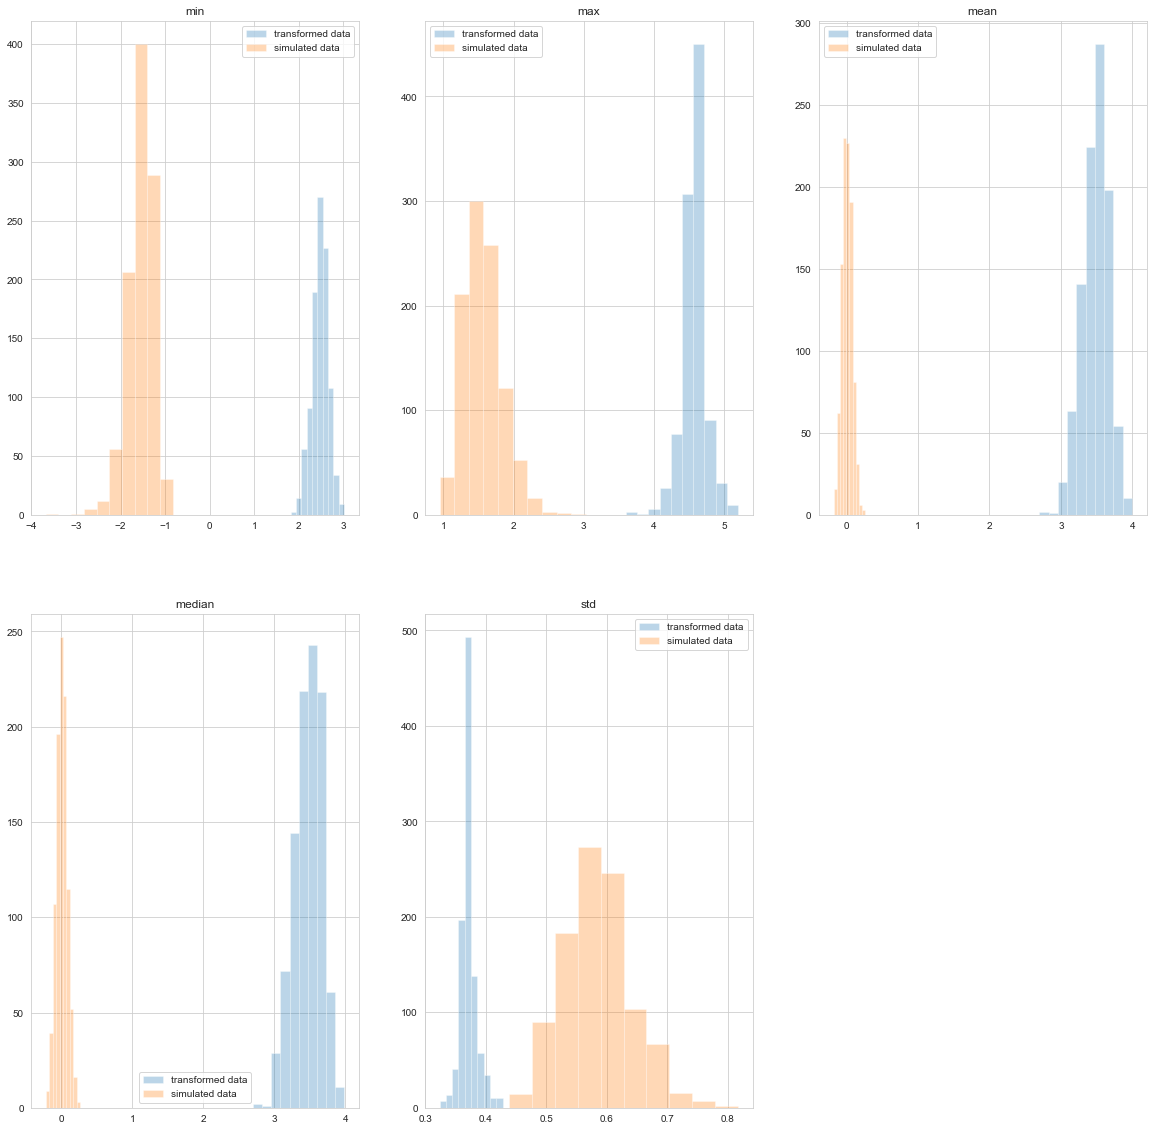

In [48]:
f = plt.figure(figsize=(20,20))

for i, var in enumerate(test_variables):
    ax = plt.subplot(2,3,i+1)
    forward = transformed_data_test_vars[[var]].values
    backward = simulated_1d_test_vars[[var]].values
    ax.hist(forward, alpha = 0.3, label = "transformed data")
    ax.hist(backward, alpha = 0.3, label = "simulated data")
    ax.legend()
    ax.set_title(var)
plt.show()

Comparing the backwards samples with the expected values of the forward test variables

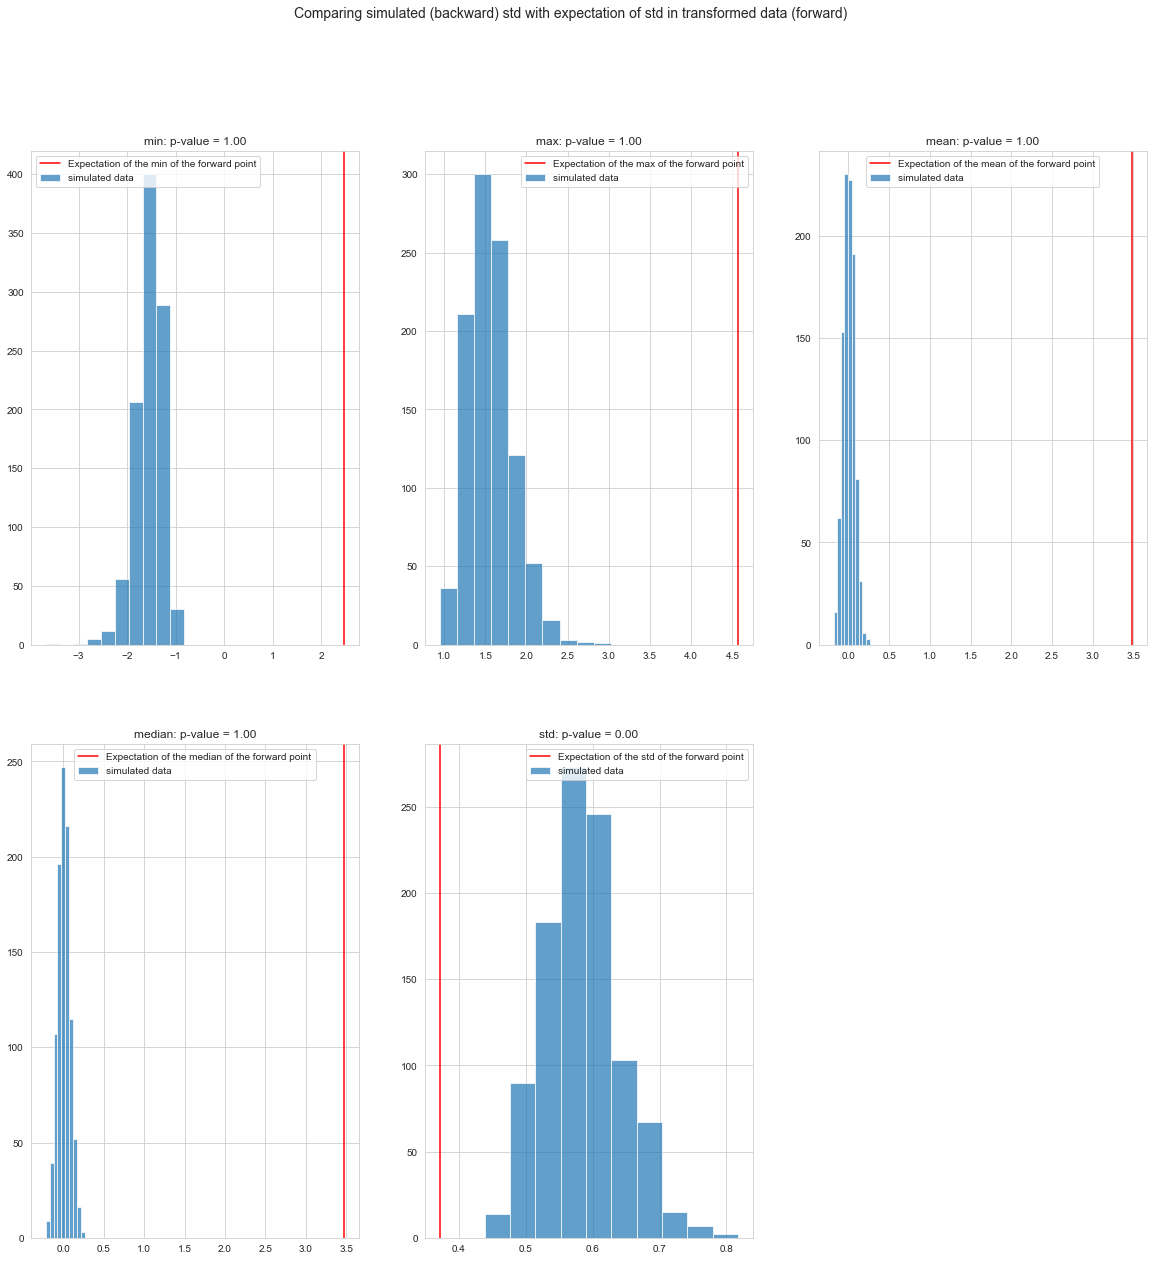

In [49]:
f = plt.figure(figsize=(20,20))

for i, var in enumerate(test_variables):
    ax = plt.subplot(2,3,i+1)
    forward_exp = np.mean(transformed_data_test_vars[[var]].values)
    backward = simulated_1d_test_vars[[var]].values
    ax.axvline(forward_exp, color="red", label = f"Expectation of the {var} of the forward point")
    ax.hist(backward, alpha = 0.7, label = "simulated data")
    # compute p-values and display them as subplot titles
    ax.set_title(var+": p-value = {:.2f}".format(                                   
        len(backward[backward < forward_exp])/len(backward)))
    ax.legend()
plt.suptitle(f"Comparing simulated (backward) {var} with expectation of {var} in transformed data (forward)", fontsize=14);
plt.show()


From the analyses above we can see that the transformed data (forward point), have higher values, as manifested in higher min, max, median and mean. Also, it has smaller std. All of these differences are significant as manifested in the extreme pvalues.

## Sensitivity Analysis

1. How does the different values of $\beta$ effect $E(\mu_i)$  and the variance of $\mu_i$-s?
2. How does the different values of $\beta$ effect on the variance across $\mu$ -s ?
3. How does the different values of $\sigma$ effect $E(\mu_i)$  and the variance of $\mu_i$-s?

In [50]:
fit_df = fit.to_dataframe()

In [51]:
fit_df['mu_std'] = fit_df[['mu[1]','mu[2]','mu[3]']].std(axis = 1)

[]

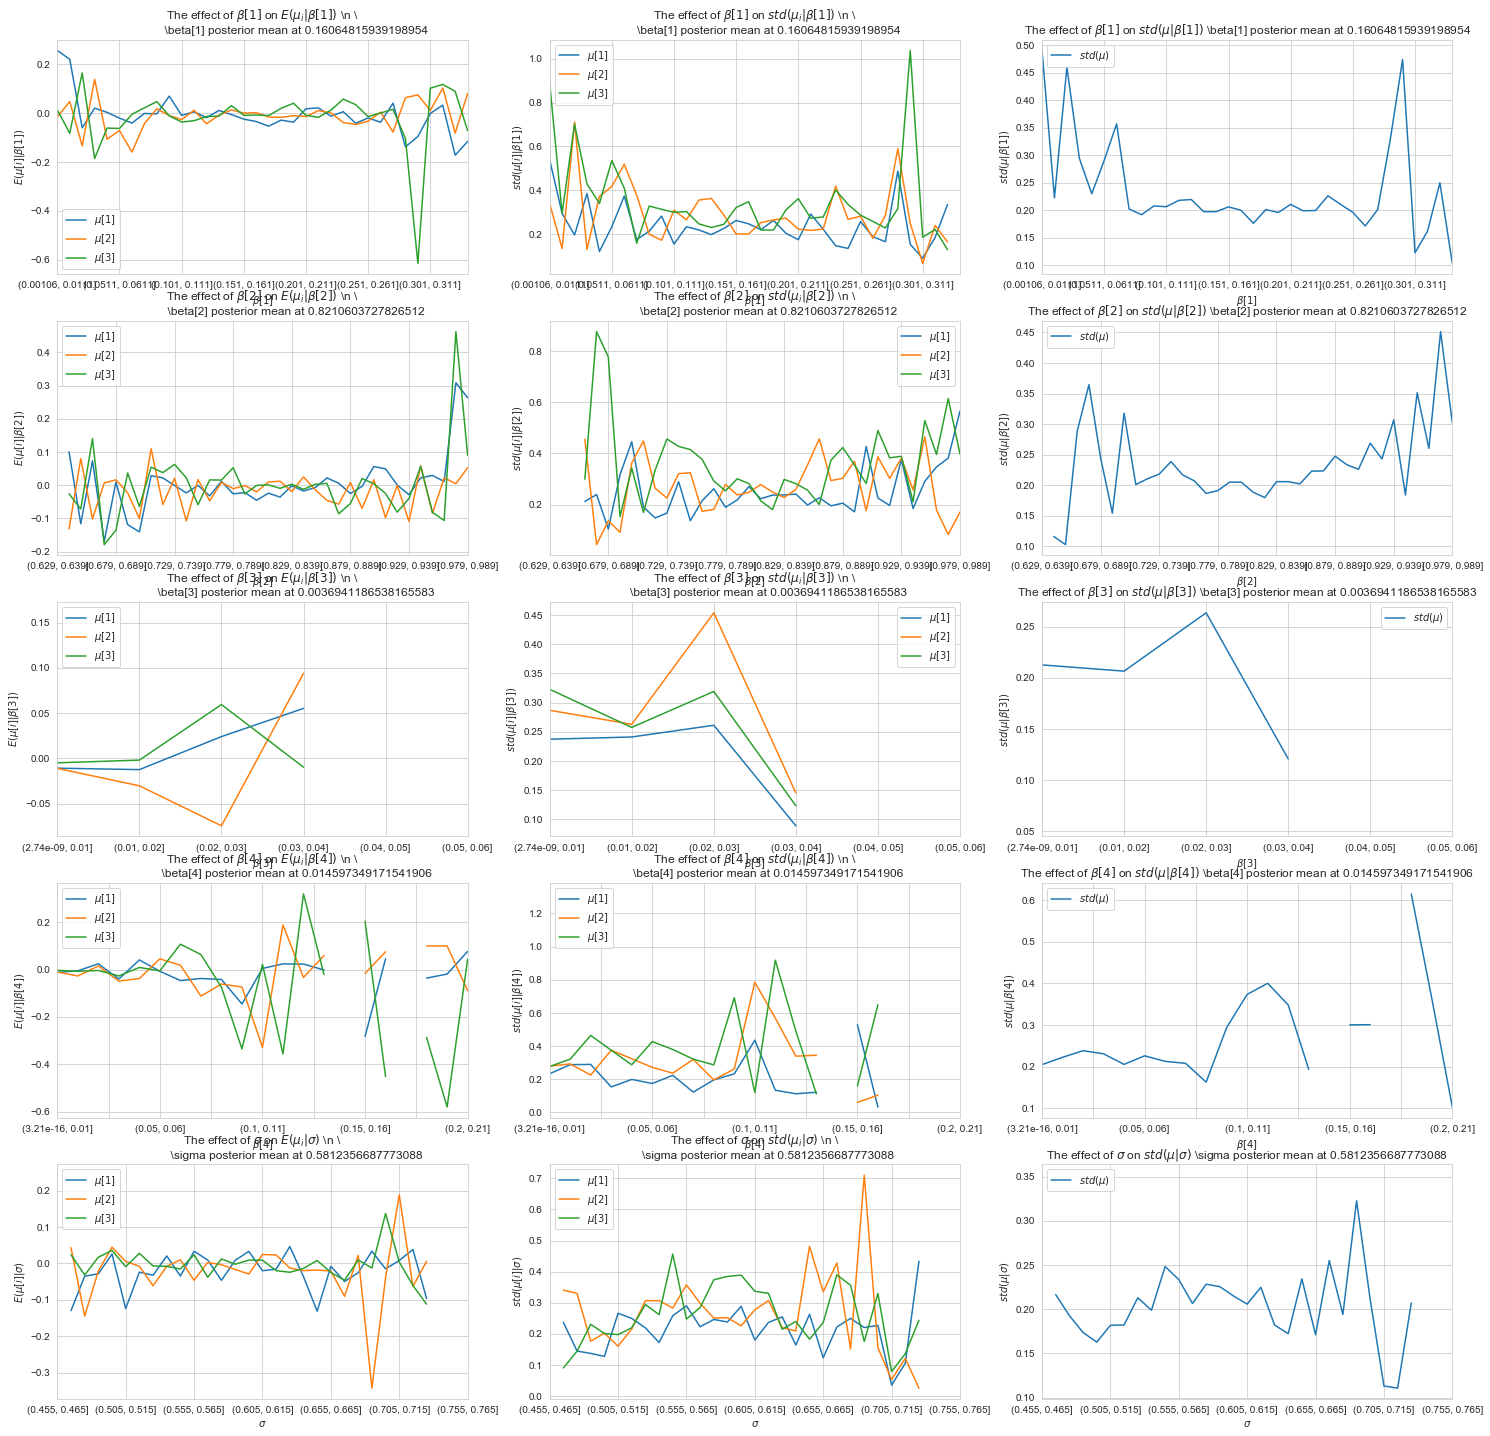

In [52]:
inc = 0.01
fig, axs = plt.subplots(5,3, sharex=False, squeeze=False, figsize = (25,25))

j = 1
for i in range(5):
    ax = axs[i][0]
    if i == 4:
        var = fit_df["sigma"]
        var_s = "sigma"
    else:    
        var = fit_df[f"beta[{i+1}]"]
        var_s = f"beta[{i+1}]"

    var_mean = var.mean()
    fit_df_mean = fit_df.groupby(pd.cut(var, np.arange(var.min(), var.max()+inc, inc))).mean()
    fit_df_std = fit_df.groupby(pd.cut(var, np.arange(var.min(), var.max()+inc, inc))).std()
    fit_df_mu_std_mean = fit_df[[var_s,'mu_std']].groupby(pd.cut(var, np.arange(var.min(), var.max()+inc, inc))).mean()


    fit_df_mean[['mu[1]','mu[2]','mu[3]']].plot(ax =ax)
    ax.set_xlabel(rf"$\{var_s}$")
    ax.set_ylabel(rf"$E(\mu[i]|\{var_s})$")
    ax.legend([r"$\mu[1]$",r"$\mu[2]$",r"$\mu[3]$"])
    ax.set_title(rf"The effect of $\{var_s}$ on $E(\mu_i | \{var_s})$ \n \
                    \{var_s} posterior mean at {var_mean}")

    ax = axs[i][1]
    fit_df_std[['mu[1]','mu[2]','mu[3]']].plot(ax = ax)
    ax.set_xlabel(rf"$\{var_s}$")
    ax.set_ylabel(rf"$std(\mu[i]|\{var_s})$")
    ax.legend([r"$\mu[1]$",r"$\mu[2]$",r"$\mu[3]$"])
    ax.set_title(rf"The effect of $\{var_s}$ on $std(\mu_i | \{var_s})$ \n \
        \{var_s} posterior mean at {var_mean}")

    ax = axs[i][2]
    # fit_df_mu_std = fit_df[['mu_std',f'beta[{i+1}]']].sort_values(by = f'beta[{i+1}]').set_index(f'beta[{i+1}]').plot(ax = ax)
    fit_df_mu_std_mean[['mu_std']].plot(ax = ax)
    ax.set_xlabel(rf"$\{var_s}$")
    ax.set_ylabel(rf"$std(\mu|\{var_s})$")
    ax.legend([r"$std(\mu)$"])
    ax.set_title(rf"The effect of $\{var_s}$ on $std(\mu | \{var_s})$ \{var_s} posterior mean at {var_mean}")
plt.plot()



## Conclusions from sensitivity analysis:
A desire property of GMM is easily distinguished clusters by having distnict centers, with minimal overlap.
This corresponds to have "different enough" mus.

Since the results depenf both on learned co-efficients and the GMM inference it is a bit hard to draw conclusive conclusions.
Change in the beta value doesn't manifest in consistent and/or monotonic behaviors in the examined parameters, therefore we can't deduce any required change to their priors.

As far as the sigma, we see that in the coverged value, the mus are quite similar. Thus we will consider using different for each component.


# 5. Expansion of the model and evaluation of the expanded model

In this section we will explore a number of alternative models:

1. A 1D GMM using only one feature (came as a conclusion from the EDA)
2. Expansion of the initial model using different sigma for each cluster

Then, we will compare these model using the NMI score which also takes into advantage the true labels.

## 1. 1D model using only one feature

In the EDA part, we saw that the pedal legnth feature can be used to distinguish between the different species.
In this model, we will use only this feature and try to model a 1D GMM using it.

In [61]:
gmm_1d_1feature = """
data {
    int<lower=1> D; // input dimensions
    int<lower=0> N; // data points number
    int<lower=1> k; // components number
    vector[N] x; // data
}


parameters
{
    simplex[k] pi; //cluster weights
    real mu[k]; //clusters' mu
    real<lower=0> sigma[k]; //clusters' sigma 
}

model {
    real ps[k]; //probability for each cluster

    pi ~ dirichlet([1,1,1]');
    
    for (i in 1:k){
        mu[i] ~ normal(3, 4); 
        log(sigma[i]) ~ normal(1, 0.1);
    }

    for(i in 1:N){
        for(j in 1:k){
            ps[j] <- log(pi[j]) + normal_log(x[i], mu[j], sigma[j]);
        }
        increment_log_prob(log_sum_exp(ps));
    }

}

"""

In [62]:
gmm_1d_1feature_model = pystan.StanModel(model_code=gmm_1d_1feature)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77fb7b448ee89b5bd29848d10a3fb800 NOW.


In [60]:
data_ = stan_data
data_['x'] = iris_df['petal length (cm)']
fit_1d_1feature = gmm_1d_1feature_model.sampling(data=stan_data, iter=10000, chains=4)

print('Sampling finished.')

Sampling finished.


## 2. Expansion of the initial model

Using conclusions from the sensitivity analysis, the expanded model has the following form:
* higher std for the clusters' mu
* smaller std for the sigma
* assign different sigmas per cluster

In [226]:
gmm_1d_expanded = """
data {
    int<lower=1> D; // input dimensions
    int<lower=0> N; // data points
    int<lower=1> k; // components number
    matrix[N,D] x; //model assumes that the data is normalized (x-x_mean)
    real mu_prior[k]; // prior for mus
    vector[D] pca_comp;
}


parameters
{
    simplex[D] beta;
    simplex[k] pi; //cluster weights
    real mu[k]; //clusters' mu
    real<lower=0> sigma[k]; //clusters' sigma 
}

model {
    real ps[k]; //probability for each cluster
    vector[N] x_1d;

    pi ~ dirichlet([1,1,1]');
    
    
    beta ~ dirichlet(pca_comp);

    for (i in 1:N){
        x_1d[i] = beta[1] * x[i,1] + beta[2] * x[i,2] + beta[3] * x[i,3] + beta[4] * x[i,4];
    }
    
    for (i in 1:k){
        mu[i] ~ normal(mu_prior[i], 2); 
        sigma[i] ~ normal(1, 0.1); 
    }

    for(i in 1:N){
        for(j in 1:k){
            ps[j] <- log(pi[j]) + normal_log(x_1d[i], mu[j], sigma[j]);
        }
        increment_log_prob(log_sum_exp(ps));
    }

}
"""

In [227]:
gmm_1d_expanded_model = pystan.StanModel(model_code=gmm_1d_expanded)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1c52634a90b2c2b359f60ed790bb9ab NOW.


In [229]:
data_ = stan_data
data_['x'] = X_norm_3
data_['pca_comp'] = pca_comp_abs.reshape(4,)
fit_1d_exapnded = gmm_1d_expanded_model.sampling(data=stan_data, iter=10000, chains=4)

print('Sampling finished.')

Sampling finished.


## Comparing the different models using NMI

In [314]:
from scipy.stats import multivariate_normal, norm

def generate_labels(data_points, mus, sigmas, pis):
    # assign each point a cluster using argmax (hard assignment)
    labels_df = pd.DataFrame(data = data_points)
    labels_df['label'] = -1
    for i, row in labels_df.iterrows():
        lls = []
        for j in range(3):
            if mus.shape == (3,):
                if len(sigmas) == 1:
                    # initial model with 1 sigma
                    lls.append(pis[j] * multivariate_normal.pdf(data_points[i], mean = mus[j], cov = sigmas))
                else:
                    #expanded model or GMM 1d
                    print("here")
                    lls.append(pis[j] * multivariate_normal.pdf(data_points[i], mean = mus[j], cov =                         sigmas[j]))
            else:
                # GMM
                lls.append(pis[j] * multivariate_normal.pdf(data_points[i], mus[j], sigmas[j], allow_singular=True))
        labels_df.at[i,'label'] = np.argmax(lls)
    return labels_df

In [388]:
from scipy.stats import norm
def generate_labels_new(data_points, mu, sigma, pi, mod):
    labels = []
    for i in range(len(data_points)):
        ll = []
        if mod == 1:
            #Univariate GMM with a single sigma
            for j in range(len(pi)):
                # ll.append(pi[i] * norm(loc=mu[i], scale=sigma).pdf(data_points[j]))
                 ll.append(pi[j] * multivariate_normal.pdf(data_points[i], mean = mu[j], cov = sigma))
        if mod == 2:
            #Univariate GMM with a multiple sigma
            for j in range(len(pi)):
                ll.append(pi[j] * multivariate_normal.pdf(data_points[i], mean = mu[j], cov = sigma[j]))
        if mod == 3:
            # Multivariate GMM
            for j in range(len(pi)):
                ll.append(pi[j] * multivariate_normal.pdf(data_points[i], mean = mu[j], cov = sigma[j]))
        labels.append(np.argmax(ll))
    return labels

In [389]:
# Univariate GMM with a single sigma
samples = fit.extract(permuted = True)
betas = np.array([samples['beta'][i].mean() for i in range(4)])
x_1d_points = X_norm_3 @ betas

mus_ = samples['mu'].mean(axis = 0)
sigma_ = samples['sigma'].mean()
pis_ = samples['pi'].mean(axis = 0)
labels_1d_ = generate_labels_new(x_1d_points, mus, sigma, pis, mod =1)

In [390]:
# Univariate GMM with multiple sigmas
samples_expanded = fit_1d_exapnded.extract(permuted=True)
betas_ex = np.array([samples_expanded['beta'][i].mean() for i in range(4)])
x_1d_points_expanded = X_norm_3 @ betas_ex

mus_ex = np.array([samples_expanded['mu'][:, i].mean() for i in range(3)])
sigmas_ex = np.array([samples_expanded['sigma'][:,i].mean() for i in range(3)])
pis_ex = np.array([samples_expanded['pi'].mean() for i in range(3)])
# generate labels for 1d expanded data
labels_1d_expanded_2 = generate_labels_new(x_1d_points_expanded, mus_ex, sigmas_ex, pis_ex, mod =2)

In [391]:
# GMM with 1d model (no transform)
samples_1feature = fit_1d_1feature.extract(permuted=True)
x_1d_points_1feature = iris_df['petal length (cm)'].values

mus_1f = np.array([samples_expanded['mu'][:, i].mean() for i in range(3)])
sigmas_1f = np.array([samples_expanded['sigma'][:,i].mean() for i in range(3)])
pis_1f = np.array([samples_expanded['pi'][:, i].mean() for i in range(3)])
# generate labels for 1d expanded data
labels_1d_1feature = generate_labels_new(x_1d_points_1feature, mus_1f, sigmas_1f, pis_1f, mod =2)

In [392]:
# multivariate GMM
samples_mvGMM = fit_base_gmm_.extract(permuted=True)
x = X

mus_mvGMM = np.array([samples_mvGMM['mu'][:,i,:].mean(axis =0) for i in range(3)])
covs_mvGMM = np.array([samples_mvGMM['L'][:,0].mean(axis = 0) for i in range(3)])
pis_mvGMM = np.array([samples_mvGMM['theta'][:, i].mean() for i in range(3)])

labels_mvGMM = generate_labels_new(x, mus_mvGMM, covs_mvGMM, pis_mvGMM, mod =3)

In [231]:

label_cat = dict()
for i, x in enumerate(iris_df.species.unique()):
    label_cat[x] = i

true_labels = iris_df.replace({'species': label_cat})['species'].values

In [393]:
# Calc MNI
from sklearn.metrics.cluster import normalized_mutual_info_score
NMI_1d = normalized_mutual_info_score(labels_1d_, true_labels, average_method='arithmetic')
NI_1d_1feature = normalized_mutual_info_score(labels_1d_1feature, true_labels, average_method = 'arithmetic')
NI_1d_expanded = normalized_mutual_info_score(labels_1d_expanded_2, true_labels, average_method = 'arithmetic')

In [394]:
print(f"The inital model has an NMI of {NMI_1d}")
print(f"The 1D model (with only one feature) has an NMI of {NI_1d_1feature}")
print(f"The expanded model has an NMI of {NI_1d_expanded}")

The inital model has an NMI of 0.6120525504856571
The 1D model (with only one feature) has an NMI of 0.705655769174682
The expanded model has an NMI of 0.4973856019817722
The multivariate GMM model has an NMI of -9.095116925862998e-16


#### We have also tried to fit a Multivariate GMM but it results in poor results:

 ## A multivariate GMM

In [53]:
base_gmm_model = """
data {
 int D; //number of dimensions
 int K; //number of gaussians
 int N; //number of data points 
 vector[D] y[N]; //data
}

parameters {
 simplex[K] theta; //mixing proportions - assignment per datum
 ordered[D] mu[K]; //mixture component means
 cholesky_factor_corr[D] L[K]; //cholesky factor of covariance
}

model {
 real ps[K];
 
 theta ~ dirichlet([1,1,1]');
 for(k in 1:K){
    log(mu[k]) ~ normal(3, 5);
    L[k] ~ lkj_corr_cholesky(4);
 }
 

 for (n in 1:N){
    for (k in 1:K){
        //increment log probability of the gaussian:
        ps[k] = log(theta[k])+multi_normal_cholesky_lpdf(y[n] | mu[k], L[k]); 
        }
        target += log_sum_exp(ps);
 }

}
"""

In [54]:
gmm_base_stan_model = pystan.StanModel(model_code=base_gmm_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9843e25a015f598c35582d4a053ca1f NOW.


In [55]:
iris_data = {
 "D":4,
 "K":3, 
 "N":150,
 "y": iris_df.drop(columns = ['species']).to_numpy()
}

In [56]:
fit_base_gmm_ = gmm_base_stan_model.sampling(data=iris_data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

In [57]:
print(fit_base_gmm_)

Inference for Stan model: anon_model_d9843e25a015f598c35582d4a053ca1f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.41     0.3   0.42 2.8e-4 4.3e-3    0.3   0.86    1.0      2  23.12
theta[2]   0.25     0.3   0.42 2.7e-4 2.9e-3 7.1e-3   0.54    1.0      2  62.76
theta[3]   0.33    0.28    0.4 4.9e-4 4.6e-3   0.14   0.72    1.0      2  22.11
mu[1,1]   1.8e7   2.0e7  4.1e7   3.45   3.74  1.2e4  2.8e6  1.4e8      4   3.11
mu[2,1]   2.1e6   1.7e6  4.1e6   3.46  73.95  1.0e5  2.5e6  1.6e7      6   1.43
mu[3,1]   1.0e6   9.7e5  1.8e6   2.55   3.01 131.69  7.9e5  6.3e6      3   1.97
mu[1,2]  2.1e12  1.1e12 3.9e13   3.46   3.74  9.6e5 3.6e10 6.2e12   1332    1.0
mu[2,2]  2.4e12  5.1e11 1.8e13   3.46  1.4e5  6.1e9 1.7e11 2.1e13   1279   1.01
mu[3,2]  1.6e12  4.0e11 1.4e13   2.56   3.02  1.4e5 2.2e10 6.9e12   1203   1.01
mu[1,3]  1.1e

In [396]:
NMI_GMM = normalized_mutual_info_score(labels_mvGMM, true_labels, average_method='arithmetic')
print(f"The multivariate GMM model has an NMI of {NMI_GMM}")

The multivariate GMM model has an NMI of -9.095116925862998e-16
